In [1]:
import sys
sys.path.append('..')

from KBSA import *

In [2]:
muL = -0.03; sigL = 0.2; sigZ = 0.3; delta = 0.2; gamma = 0.8; rho=-.95
def generate_rv(muL):  
    L = random.normalvariate(muL, sigL)
    xi = sigZ*(rho*(L-muL)/sigL+(1-rho**2)**0.5*random.normalvariate(0, 1))
    Z = delta*L+0.5*gamma*L**2+xi
    return (Z, L)
    
d = 1
phi, psi = 0.95, 0.95

vL_true = muL+norm.ppf(phi)*sigL
co_true = delta*vL_true+0.5*gamma*vL_true**2+sigZ*(rho*norm.ppf(phi)+(1-rho**2)**0.5*norm.ppf(psi))
dvL_true = np.array([1])
dco_true = delta*dvL_true+gamma*vL_true*dvL_true

In [3]:
N = 1e5
init_v = 0
cst, cst_h1, cst_h2, cst_c = 6,.1,.1,3
set_v, set_co, bound_D = [0,.5],[-1,0],np.inf

# 1） one round of the algorithm implementation

In [6]:
with np.errstate(invalid='raise'):
    try:
        co, v, Dv, Dco = sensitivity(N, psi, phi, d, muL, generate_rv, init_v,
                                    cst, cst_h1, cst_h2, cst_c,
                                    set_v, set_co, bound_D)
        print('-'*40)
        print('Estimate')
        print('VaR:', round(v[-1], 3))
        print('DVaR:', [round(Dv[-1][j], 3) for j in range(d)])
        print('CoVaR:', round(co[-1],3))
        print('DCoVaR:', [round(Dco[-1][j], 3) for j in range(d)])
        
        print('-'*40)
        print('True Value')
        print('VaR:', round(vL_true, 3))
        print('DVaR:', [round(dvL_true[j], 3) for j in range(d)])
        print('CoVaR:', round(co_true,3))
        print('DCoVaR:', [round(dco_true[j], 3) for j in range(d)])
        print('-'*40)
    except (FloatingPointError, ZeroDivisionError):
        print('Error: Division by Zero')

----------------------------------------
Estimate
VaR: 0.299
DVaR: [0.999]
CoVaR: -0.213
DCoVaR: [0.437]
----------------------------------------
True Value
VaR: 0.299
DVaR: [1]
CoVaR: -0.219
DCoVaR: [0.439]
----------------------------------------


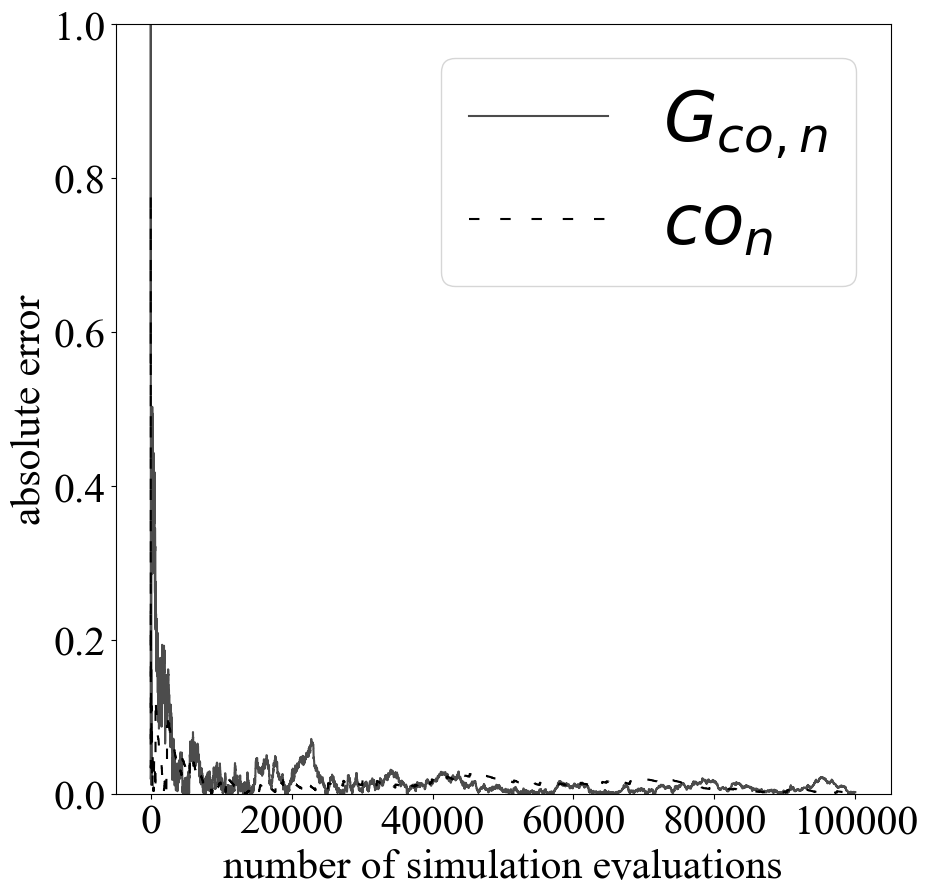

In [7]:
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = [np.linalg.norm(Dco[i]-dco_true)/d**.5 for i in range(len(Dco))]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

error = [abs(co_-co_true) for co_ in co]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = (0,(5,10)))

plt.ylim(0,1)
plt.legend(fontsize=50)
plt.ylabel('absolute error')
plt.xlabel('number of simulation evaluations')
plt.show()

# 2) 100 independent replications

### implementation & save results (We have already generated and saved results in the 'results/' directory. Please skip this part and proceed to 'descriptive statistics'.)

In [ ]:
cst=3
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, muL, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/nonlinear3.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=6
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, muL, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/nonlinear6.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=9
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, muL, generate_rv, init_v,
                            cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D)
with open('../results/nonlinear9.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

### descriptive statistics

In [8]:
# with open('../results/nonlinear3.pkl', 'rb') as f:
with open('../results/nonlinear6.pkl', 'rb') as f:
# with open('../results/nonlinear9.pkl', 'rb') as f:
    co_lst, v_lst, Dv_lst, Dco_lst = pickle.load(f)

In [9]:
mean_lst_co = np.mean(co_lst, axis=0)
mean_lst_Dco = np.mean(Dco_lst, axis=0)

bias_lst_co = [m-co_true for m in mean_lst_co]
bias_lst_Dco = [m-dco_true for m in mean_lst_Dco]

In [11]:
AE_lst_co = [[abs(i-co_true) for i in co_lst[j]] for j in range(len(co_lst))]
MAE_lst_co = np.mean(AE_lst_co, axis=0)

AE_lst_Dco = [[np.linalg.norm(i-dco_true) for i in Dco_lst[j]] for j in range(len(Dco_lst))]
MAE_lst_Dco = np.mean(AE_lst_Dco, axis=0)

In [12]:
SE_lst_co = [[abs(i-co_true)**2 for i in co_lst[j]] for j in range(len(co_lst))]
RMSE_lst_co = np.mean(SE_lst_co, axis=0)**.5

SE_lst_Dco = [[np.linalg.norm(i-dco_true)**2 for i in Dco_lst[j]] for j in range(len(Dco_lst))]
RMSE_lst_Dco = np.mean(SE_lst_Dco, axis=0)**.5

In [13]:
print('CoVaR estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_co[k]/np.linalg.norm(co_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_co[k],3))
    print('bias:', round(bias_lst_co[k],4))
    print('RMSE: ',round(RMSE_lst_co[k],3))

CoVaR estimation
----- 100 -----
relative error:  41.39 %
MAE:  0.091
bias: 0.0626
RMSE:  0.108
----- 1000 -----
relative error:  18.44 %
MAE:  0.04
bias: 0.0287
RMSE:  0.053
----- 10000 -----
relative error:  7.08 %
MAE:  0.016
bias: 0.0086
RMSE:  0.02
----- 100000 -----
relative error:  2.74 %
MAE:  0.006
bias: 0.0029
RMSE:  0.008


In [16]:
print('CoVaR gradient estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_Dco[k]/np.linalg.norm(dco_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_Dco[k],4))
    print('bias:', round(bias_lst_Dco[k][0],4))
    print('RMSE: ',round(RMSE_lst_Dco[k],4))

CoVaR gradient estimation
----- 100 -----
relative error:  80.13 %
MAE:  0.3519
bias: 0.0275
RMSE:  0.4001
----- 1000 -----
relative error:  33.04 %
MAE:  0.1451
bias: 0.029
RMSE:  0.1682
----- 10000 -----
relative error:  5.98 %
MAE:  0.0263
bias: -0.0008
RMSE:  0.0328
----- 100000 -----
relative error:  1.77 %
MAE:  0.0078
bias: -0.0026
RMSE:  0.0099


### data visualization

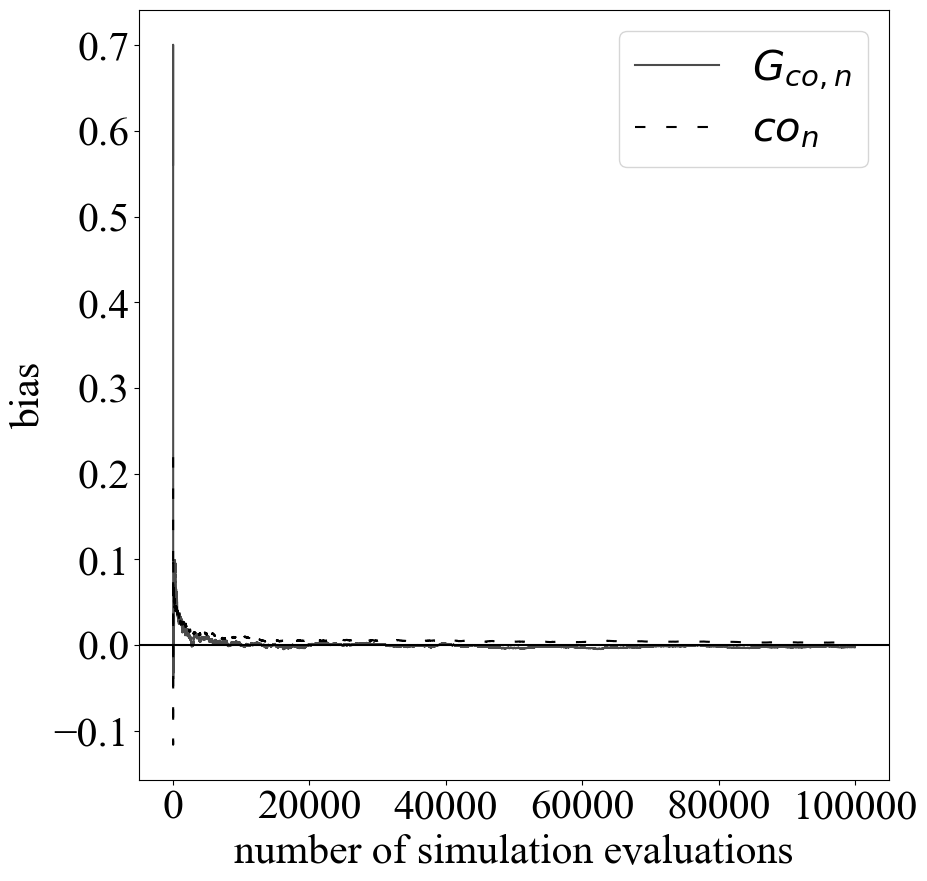

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = bias_lst_Dco
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

error = bias_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = next(style))

plt.axhline(0, color = 'k', alpha = 1, linestyle = '-')
plt.ylabel('bias')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.xlabel('number of simulation evaluations')
plt.show()

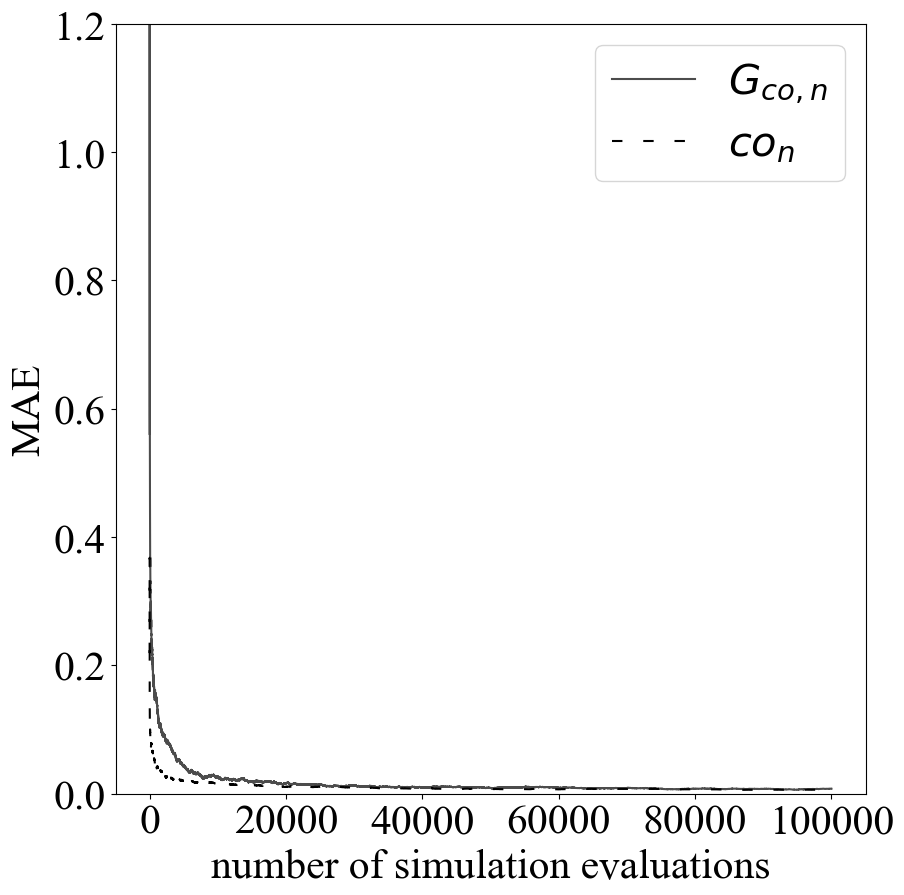

In [18]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = MAE_lst_Dco
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))


error = MAE_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = next(style))

plt.ylim(0,1.2)
plt.ylabel('MAE')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.xlabel('number of simulation evaluations')
plt.show()

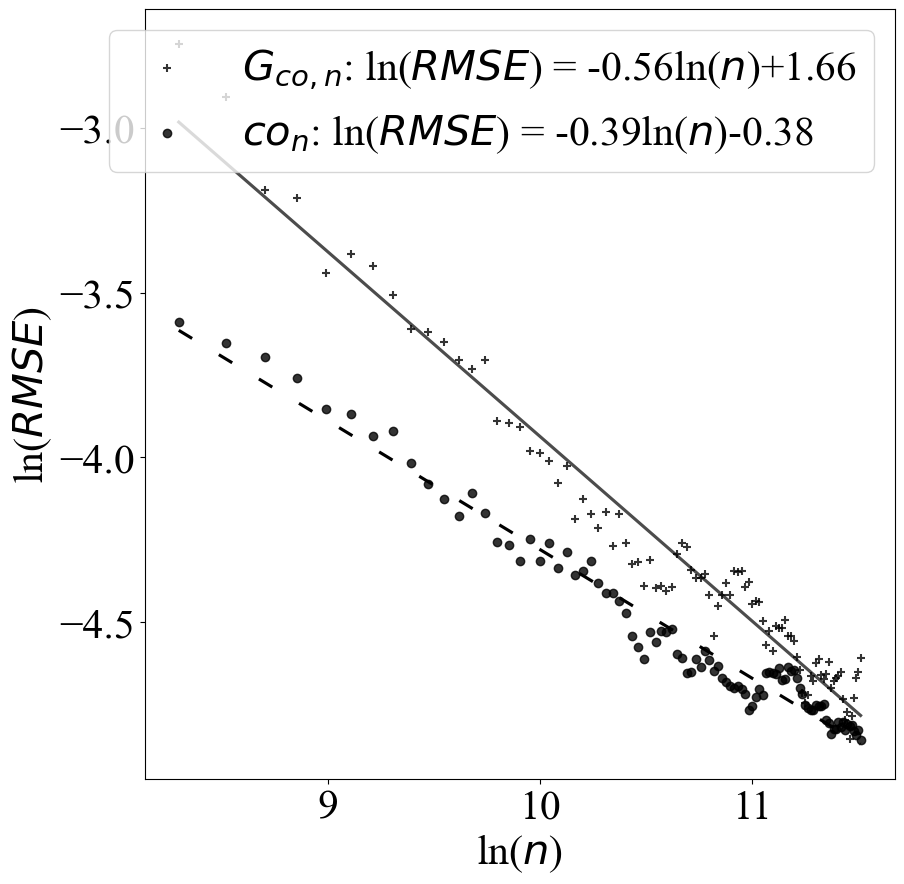

In [19]:
N=1e5
start = int(4e3)
step = int(1e3)
logn = [math.log(n+1) for n in range(start, int(N+1))][::step]

plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['font.family'] = ['Times New Roman']
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

y=[math.log(rmse) for rmse in RMSE_lst_Dco][start:int(N+1):step]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y ,ci = None, 
            label =  r'$G_{co,n}$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)+'+str(round(intercept,2)),
            color='k', marker = '+', line_kws=dict(alpha = .7, color="k", linestyle = next(style)))

y=[math.log(rmse) for rmse in RMSE_lst_co][start:int(N+1):step]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y, ci = None,
           label = r'$co_n$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)'+str(round(intercept,2)),
           color='k', marker = 'o', line_kws=dict(color="k", linestyle = next(style)))

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.ylabel('ln($RMSE$)')
plt.xlabel('ln($n$)')
plt.show() 